# Experiment ensemble prediction.

Goal: use a very simple setup (only [0,-1] timesteps), early stopping and a simple or no scheduler to have a look at the ensemble predictions.


Therefore, it seems as if we need the following dataset ID: 278771

We have three experiments, one with a constant learning rate at 1e-4:

MID: 67D778

and one with a learning rate that decreases on plateaus:

MID: 542704

and one, without early stopping:

MID: BB7742

In [12]:
import xarray as xr
import numpy as np
import torch
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

import matplotlib
import matplotlib.pyplot as plt

import copy
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

import cartopy.crs as ccrs

In [13]:
ds = xr.open_dataset("/data/compoundx/WeatherDiff/model_input/13B689_output_min_max.nc")

In [14]:
ds_id_2 = "278771"
ds_id_3 = "93EB03"

# model_id_1 = "DC855F"
model_id_2 = "8841D8"
model_id_3 = "BCE7BB"

# targets_1 = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id_1}_target.nc")
# predictions_1 = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id_1}_gen.nc")

targets_2 = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id_2}/{model_id_2}_target.nc")
predictions_2 = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id_2}/{model_id_2}_gen.nc")

targets_3 = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id_3}/{model_id_3}_target.nc")
predictions_3 = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id_3}/{model_id_3}_gen.nc")

In [15]:
targets_3

<xarray.Dataset>
Dimensions:          (lat: 32, lon: 64, lead_time: 1, ensemble_member: 1,
                      init_time: 2903)
Coordinates:
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lead_time        (lead_time) int64 12
  * ensemble_member  (ensemble_member) int64 0
  * init_time        (init_time) datetime64[ns] 2017-01-01T12:00:00 ... 2018-...
Data variables:
    z                (ensemble_member, init_time, lead_time, lat, lon) float32 ...

In [16]:
# rmse_1 = compute_weighted_rmse(predictions_1, targets_1)
# print("RMSE 1 is {:.1f}".format(rmse_1.z_500.values))

# mae_1 = compute_weighted_mae(predictions_1, targets_1)
# print("MAE 1 is {:.1f}".format(mae_1.z_500.values))

# acc_1 = compute_weighted_acc(predictions_1.rename_dims({"init_time":"time"}), targets_1.rename_dims({"init_time":"time"}))
# print("ACC 1 is {:.2f}".format(acc_1.z_500.values))

rmse_2 = compute_weighted_rmse(predictions_2.isel({"ensemble_member":0}), targets_2.isel({"ensemble_member":0}))
print("RMSE 2 is {:.1f}".format(rmse_2.z_500.values))

mae_2 = compute_weighted_mae(predictions_2.isel({"ensemble_member":0}), targets_2.isel({"ensemble_member":0}))
print("MAE 2 is {:.1f}".format(mae_2.z_500.values))

acc_2 = compute_weighted_acc(predictions_2.isel({"ensemble_member":0}), targets_2.isel({"ensemble_member":0}))
print("ACC 2 is {:.2f}".format(acc_2.z_500.values))

rmse_3 = compute_weighted_rmse(predictions_3.isel({"ensemble_member": 0}), targets_3.isel({"ensemble_member": 0}))
print("RMSE 3 is {:.1f}".format(rmse_3.z.values))

mae_3 = compute_weighted_mae(predictions_3.isel({"ensemble_member": 0}), targets_3.isel({"ensemble_member": 0}))
print("MAE 3 is {:.1f}".format(mae_3.z.values))

acc_3 = compute_weighted_acc(predictions_3.isel({"ensemble_member": 0}), targets_3.isel({"ensemble_member": 0}))
print("ACC 3 is {:.2f}".format(acc_3.z.values))

"""
rmse_3 = compute_weighted_rmse(predictions_3.isel({"ensemble_member": 1}), targets_3.isel({"ensemble_member": 0}))
print("RMSE 3,member 2 is {:.1f}".format(rmse_3.z.values))

mae_3 = compute_weighted_mae(predictions_3.isel({"ensemble_member": 1}), targets_3.isel({"ensemble_member": 0}))
print("MAE 3,member 2 is {:.1f}".format(mae_3.z.values))

acc_3 = compute_weighted_acc(predictions_3.isel({"ensemble_member": 1}), targets_3.isel({"ensemble_member": 0}))
print("ACC 3,member 2 is {:.2f}".format(acc_3.z.values))
"""


RMSE 2 is 625.0
MAE 2 is 386.4
ACC 2 is 0.82
RMSE 3 is 606.6
MAE 3 is 376.0
ACC 3 is 0.83


'\nrmse_3 = compute_weighted_rmse(predictions_3.isel({"ensemble_member": 1}), targets_3.isel({"ensemble_member": 0}))\nprint("RMSE 3,member 2 is {:.1f}".format(rmse_3.z.values))\n\nmae_3 = compute_weighted_mae(predictions_3.isel({"ensemble_member": 1}), targets_3.isel({"ensemble_member": 0}))\nprint("MAE 3,member 2 is {:.1f}".format(mae_3.z.values))\n\nacc_3 = compute_weighted_acc(predictions_3.isel({"ensemble_member": 1}), targets_3.isel({"ensemble_member": 0}))\nprint("ACC 3,member 2 is {:.2f}".format(acc_3.z.values))\n'

In [11]:
n_images = 2
timesteps = np.random.choice(np.arange(len(predictions_3["init_time"])), size=(n_images,))

In [21]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

# Plotting:

In [24]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": True,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

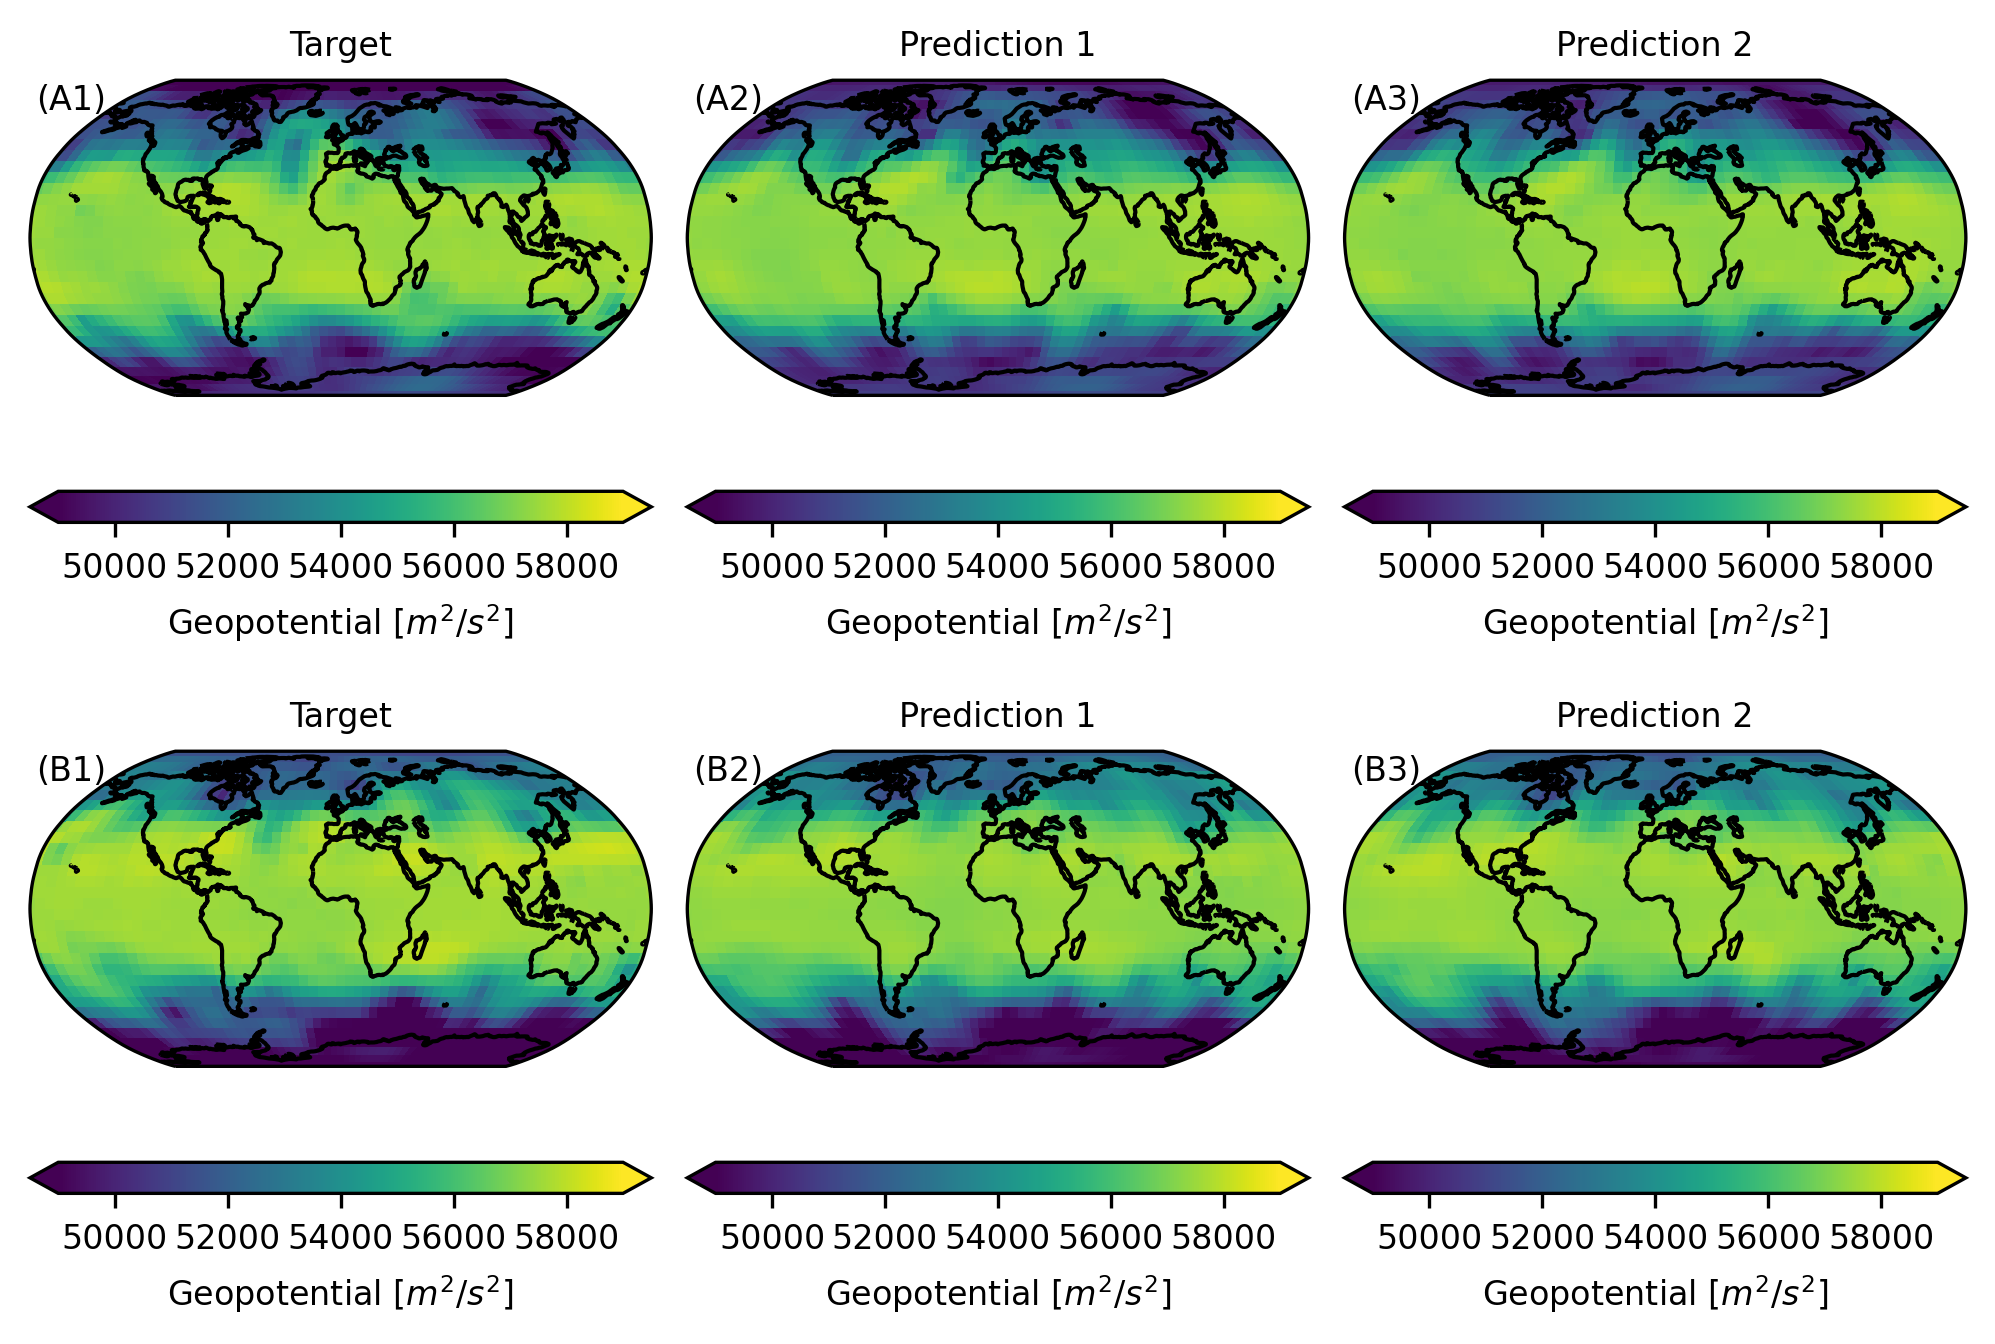

In [27]:
n_rows = n_images
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = 1.3 * textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, i_t in enumerate(timesteps):
    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets_3.isel({"init_time":i_t, "lead_time":0, "ensemble_member":0})[list(targets_3.keys())], plotting_config=config, title="Target")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 1], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions_3.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(predictions_3.keys())], plotting_config=config, title="Prediction 1")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 2], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions_3.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 1})[list(predictions_3.keys())], plotting_config=config, title="Prediction 2")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}3)".format(alphabet_letters[i]))


fig.canvas.draw()
fig.tight_layout()

plt.show()